### Empathy and polarity prediction - Woebot
I generally work in Spyder but I thought it would make evaluation easier if I provided this in a notebook. When I'm discussing things below I may include screenshots of dataframes to make a point - they'll be taken from Spyder.

### DATA MUNGING

Before importing into Python I've manually gone through the dataset and done some cleaning of the data - 
as much to familiarise myself with what's going on as anything.

For example, there were a number of instances with emoticon codes, which I've converted to words in the instance.

![The Emoticon](img/emoticon.png) ![In Unicode](img/emoticon_unicode.png)

So I've replaced every 'tired' emoticon with the word 'tired', 'smile' emoticon with 'smile', 'flowers' emoticon with 'flowers' etc.

To begin with below I'm going to explore the data a little bit more and highlight data cleaning issues.

'''
Snippets of code have been used from the following links:

https://www.dataquest.io/blog/natural-language-processing-with-python/
https://heartbeat.fritz.ai/guide-to-saving-hosting-your-first-machine-learning-model-cdf69729e85d

Glove
https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb

Normalise text
From: https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk
https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk

'''

In [1]:
# Importing some standard stuff

import pandas as pd
import numpy as np
import re, string
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# For one hot encoding
from sklearn.preprocessing import MultiLabelBinarizer

import nltk
# https://www.guru99.com/tokenize-words-sentences-nltk.html
from nltk.tokenize import word_tokenize # word tokenize
from nltk.corpus import stopwords
# from nltk import ne_chunk

# text normalisation (converting a word to its canonical form - ran, runs, 
# running are forms of 'run')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# for named entity recognition
nltk.download('maxent_ne_chunker')
nltk.download('words')

# part of sentence
from nltk.tag import pos_tag

# Lemmatisation
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline
pd.set_option('display.max_colwidth', 300)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/billcoleman/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/billcoleman/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/billcoleman/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/billcoleman/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [22]:
'''
Importing data
You'll see below that I added some columns into the dataset when I was getting to know it - 'order', just saved 
the specific order I found the table in, 'core' I used to mark messages which used only an empathy word, or a
close relation of an empathy word.
'''
# Load dataset
empathy_data_all = pd.read_csv("machine-learning-engineer/labeled_messages_munge.csv", sep = ',')
print(empathy_data_all.head())
print(empathy_data_all.shape)

# Load empathy polarities
empathy_polarity = pd.read_csv("machine-learning-engineer/empathies.csv", sep = ',')
print(empathy_polarity.head())
print("There are: ", len(empathy_polarity['polarity']), "entries in the empathy polarity table.")

   num_seen message empathy ignore  order core
0      3237    good    good    NaN    101  NaN
1      2884   tired   tired    NaN      1    x
2      1700   happy   happy    NaN    102    x
3      1559    okay    okay    NaN    401    x
4      1311     sad     sad    NaN    201    x
(3562, 6)
        empathy  polarity
0  affectionate       1.0
1         angry      -1.0
2       annoyed      -0.8
3       anxious      -1.0
4       average       0.0
There are:  61 entries in the empathy polarity table.


In [23]:
'''
Clean up empathy labels in dataset
'''

def clean_empathies(empathy_data_all):
    '''
    Step through all entries in the empathy vector to make processing a bit easier.
    '''
    
    empathies = [] 

    # extract empathies
    for i in empathy_data_all['empathy']:
        # split words
        words = nltk.word_tokenize(i)
        # remove punctuation
        words=[word.lower() for word in words if word.isalpha()]
        empathies.append(words)
    
    return empathies

# add to 'empathy_data_all' dataframe  
empathy_data_all['empathies_new'] = empathies = clean_empathies(empathy_data_all)

In [24]:
print(empathy_data_all['empathy'][22])
print(empathy_data_all.shape)

okay
(3562, 7)


In [25]:
'''
Check unique empathy labels
'''

def make_unique_empathies_list(empathy_data_all):
    '''
    Make a list all unique empathies
    '''
    
    unique_empathy_labels = []

    for i in empathy_data_all['empathies_new']:
        for j in i:
            if j not in unique_empathy_labels:
                unique_empathy_labels.append(j)
    
    return unique_empathy_labels

unique_empathy_labels = make_unique_empathies_list(empathy_data_all)

print("There are: ", len(unique_empathy_labels), "unique empathy labels.")
print(unique_empathy_labels)

There are:  62 unique empathy labels.
['good', 'tired', 'happy', 'okay', 'sad', 'calm', 'great', 'anxious', 'stress', 'sleep', 'depressed', 'bored', 'angry', 'emotionless', 'average', 'annoyed', 'lonely', 'hungry', 'confused', 'stable', 'hopeful', 'lazy', 'unsatisfied', 'disconnected', 'relief', 'idk', 'determined', 'scared', 'better', 'pain', 'unmotivated', 'engaged', 'embarrassed', 'regret', 'full', 'intoxicated', 'inspired', 'restless', 'pensive', 'confidence', 'sexy', 'distortion', 'emotional', 'affectionate', 'creative', 'vulnerable', 'despair', 'excited', 'loss', 'upset', 'uneasy', 'sick', 'uncertain', 'flustered', 'playful', 'healthy', 'ignored', 'loved', 'jealous', 'surprised', 'rude', 'frustrated']


In [26]:
# Find mismatches between labels in dataset and the empathy polarity table

def identify_mismatches(empathy_polarity, unique_empathy_labels):
    '''
    Identify mismatches between the labels in the dataset and those in the empathy table
    '''
    for i in empathy_polarity['empathy']:
        if i not in unique_empathy_labels:
            print("NOT IN unique_empathy_labels: ", i)

    for i in unique_empathy_labels:
        if i not in list(empathy_polarity['empathy']):
            print("NOT IN empathy_polarity_table['empathy']: ", i)

identify_mismatches(empathy_polarity, unique_empathy_labels)

NOT IN unique_empathy_labels:  panic
NOT IN unique_empathy_labels:  thirsty
NOT IN empathy_polarity_table['empathy']:  good
NOT IN empathy_polarity_table['empathy']:  hopeful
NOT IN empathy_polarity_table['empathy']:  frustrated


In [27]:
'''
So, 'panic' and 'thirsty' are not present as labels in the dataset.
Also, we need polarity values for 'good', 'hopeful' and 'frustrated' as these don't exist in the polarities table.
'''

# Creating a dict to add these 
df_new = pd.DataFrame({"empathy":['good', 'hopeful', 'frustrated'], 
                    "polarity":[0.8, 0.8, -0.8]})

empathy_polarity = empathy_polarity.append(df_new, ignore_index=True)
empathy_polarity.shape

(64, 2)

In [28]:
'''
I'm going to summarise the polarity score for every entry
'''

def get_polarity_score(empathies):
    
    '''
    Step through each list of empathies and sum the polarity value to get an
    'overall empathy score' for the instance.
    '''

    polarities = []
    
    for i in empathies:
        
        # temporary variable to sum polarities
        temp = 0
        
        for j in range(len(i)):
            temp += np.float(empathy_polarity['polarity'].loc[empathy_polarity['empathy'] == i[j]])
        
        polarities.append(temp)
    
    return polarities


polarities = get_polarity_score(empathies)

empathy_data_all['cum_polarity'] = polarities

print("There are: ", np.sum(np.array(polarities) > 0, axis=0), "cumulative polarities > 0")
print("There are: ", np.sum(np.array(polarities) < 0, axis=0), "cumulative polarities < 0")
print("There are: ", np.sum(np.array(polarities) == 0, axis=0), "cumulative polarities == 0")

There are:  1134 cumulative polarities > 0
There are:  2188 cumulative polarities < 0
There are:  240 cumulative polarities == 0


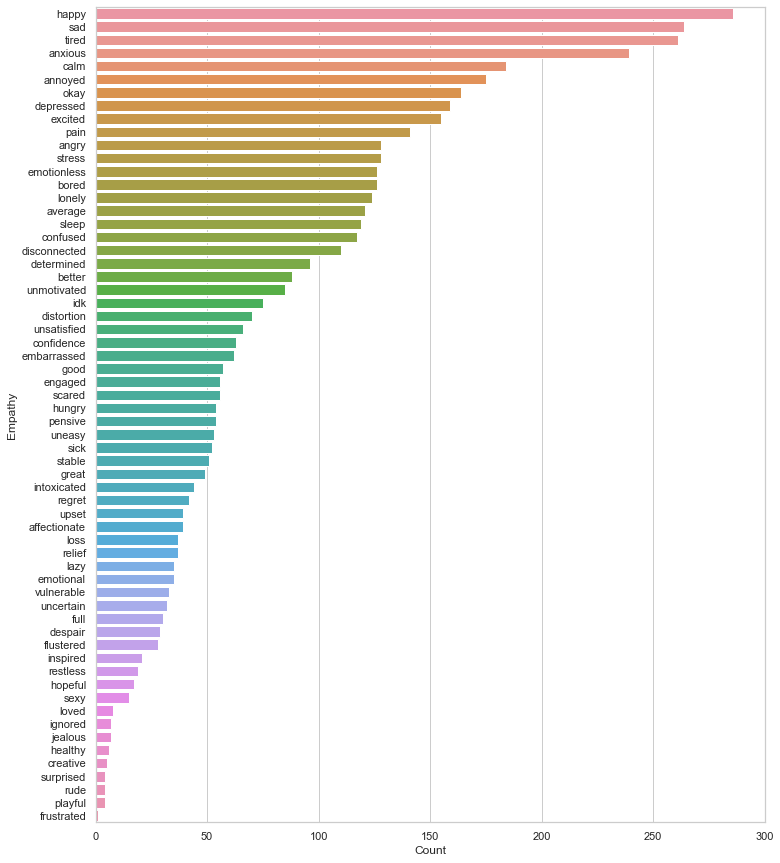

In [29]:
'''
Collapse all empathy occurences to a list. Then we can count the number of occurences and get a better idea of
what we're dealing with.
'''
all_empathies = sum(empathies,[])
len(set(all_empathies))

empathies_occ_count = np.unique(all_empathies, return_counts=True)

# create dataframe
empathies_occ_count_df = pd.DataFrame({'Empathy': list(empathies_occ_count[0]), 
                              'Count': list(empathies_occ_count[1])})

# Visualise empathy occurence
g = empathies_occ_count_df.nlargest(columns="Count", n = 62) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Empathy") 
ax.set(ylabel = 'Empathy') 
plt.show()

The dataset is severely imbalanced which is going to have an effect on end accuracy. There are a couple of implications for train/test splits and so on - there's no hope of stratifying them for instance as I'd have to use a different split for each individual model and these wouldn't then be comparable. One of the labels is 'frustration' - only appears once - I think I can safely change this to 'annoyed'. The other low occurring labels I don't think have equivalents so I'm going to leave them as they are.

In [30]:
# Replacing 'frustration'
frust_idx = empathy_data_all[empathy_data_all['empathy'].str.contains("frustrated")]
print(empathy_data_all['empathy'].iloc[frust_idx.index])
empathy_data_all['empathy'].iloc[frust_idx.index] = 'scared,anxious,annoyed,angry'

3073    scared,anxious,frustrated,angry
Name: empathy, dtype: object


/Users/billcoleman/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
# Check the replacement has been correctly applied.
print(empathy_data_all['empathy'].iloc[frust_idx.index])

3073    scared,anxious,annoyed,angry
Name: empathy, dtype: object


There are:  61 unique empathy labels.
['good', 'tired', 'happy', 'okay', 'sad', 'calm', 'great', 'anxious', 'stress', 'sleep', 'depressed', 'bored', 'angry', 'emotionless', 'average', 'annoyed', 'lonely', 'hungry', 'confused', 'stable', 'hopeful', 'lazy', 'unsatisfied', 'disconnected', 'relief', 'idk', 'determined', 'scared', 'better', 'pain', 'unmotivated', 'engaged', 'embarrassed', 'regret', 'full', 'intoxicated', 'inspired', 'restless', 'pensive', 'confidence', 'sexy', 'distortion', 'emotional', 'affectionate', 'creative', 'vulnerable', 'despair', 'excited', 'loss', 'upset', 'uneasy', 'sick', 'uncertain', 'flustered', 'playful', 'healthy', 'ignored', 'loved', 'jealous', 'surprised', 'rude']


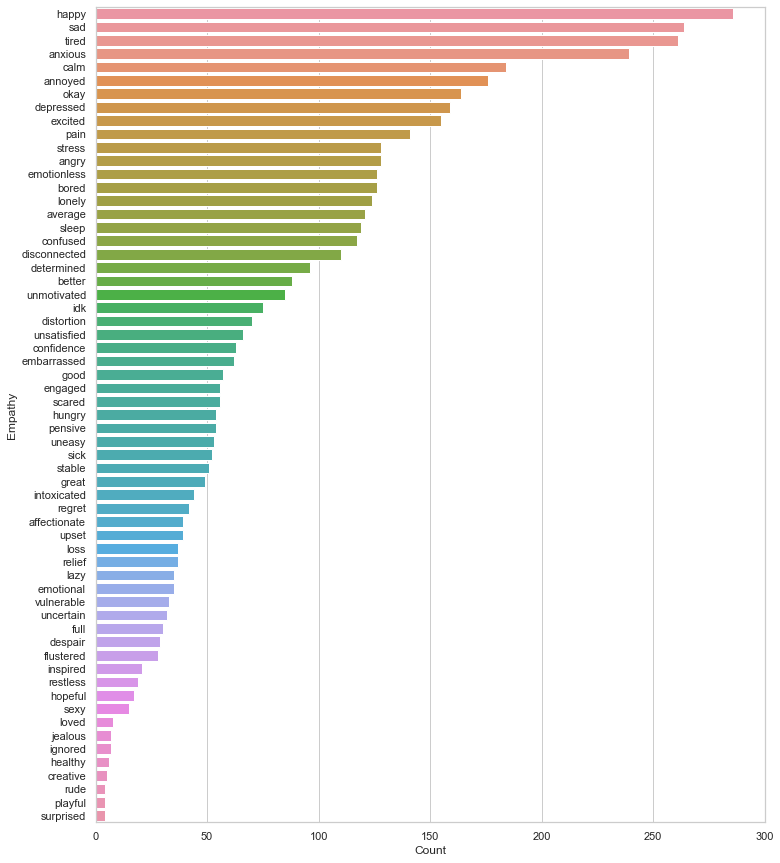

In [32]:
# Reconstitute these objects 
empathy_data_all['empathies_new'] = empathies = clean_empathies(empathy_data_all)

unique_empathy_labels = make_unique_empathies_list(empathy_data_all)

print("There are: ", len(unique_empathy_labels), "unique empathy labels.")
print(unique_empathy_labels)

# And run the plot again
all_empathies = sum(empathies,[])
len(set(all_empathies))

empathies_occ_count = np.unique(all_empathies, return_counts=True)

# create dataframe
empathies_occ_count_df = pd.DataFrame({'Empathy': list(empathies_occ_count[0]), 
                              'Count': list(empathies_occ_count[1])})

# Visualise empathy occurence
g = empathies_occ_count_df.nlargest(columns="Count", n = 62) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Empathy") 
ax.set(ylabel = 'Empathy') 
plt.show()

In [59]:
'''
Removing noise from the data - punctuation, html etc (copied from a twitter project)
'''

stop_words = stopwords.words('english')

'''
'down' and 'up' are stopwords. 'down' particularly might be used instead of
sad here, so I'm removing it from stopwords
There was a bit of back and forth here. Initially used defaults then tweaked as I proceeded.
Candidates to be added to stopwords for this specific application - 'little' & 'bit' - removing these improved 
performance slightly
'''

stop_words.remove('down')
stop_words.remove('up')
stop_words.remove('so')
stop_words.remove('can')
stop_words.remove('not')
stop_words.remove('in')
stop_words.remove('between')
stop_words.remove('now')

stop_words.append('little')
stop_words.append('bit')


'''
Tokenize text
'''

def tokenize_text(empathy_data_all):
    
    '''
    Some text cleaning and word tokenization
    '''
    text_tokens = []

    for i in range(len(empathy_data_all['message'])):
        # replace the \\n which denote line returns
        tokenized = empathy_data_all['message'][i].replace('\\n', ' ')
        # tokenize the message
        tokenized = word_tokenize(tokenized)
        text_tokens.append(tokenized)
    
    return text_tokens

text_tokens = tokenize_text(empathy_data_all)


def remove_noise(tweet_tokens, stop_words = ()):
    
    '''Removing unwanted characters from tokens'''

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # to deal with line returns - fell over because of \\n
        # taken care of in a seperate function
        # token = re.sub(r'/\r?\n|\r/', '', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub(r'[,@\'?\.$%_:\-"’“”]', "", token, flags=re.I)
        
        # Still some unicode characters such as 'Ã®m' that could be cleaned

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and \
            token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
        # else:
            # print(token)
    
    cleaned_string = ''
    for i in range(len(cleaned_tokens)):
        cleaned_string = cleaned_string + cleaned_tokens[i]
        if i < len(cleaned_tokens) - 1:
            cleaned_string = cleaned_string + ' '
        
    return cleaned_tokens, cleaned_string


'''
Applying normalisation and cleaning to all text, store in object
'''

cleaned_text_tokens = []
cleaned_text_str = []

for tokens in text_tokens:
    tk, st = remove_noise(tokens, stop_words)
    cleaned_text_tokens.append(tk)
    cleaned_text_str.append(st)

# compare before with after
print(empathy_data_all['message'][1228])
print(text_tokens[1228])
print(cleaned_text_tokens[1228])
print(empathy_data_all['message'][1346])
print(text_tokens[1346])
print(cleaned_text_tokens[1346])

a little bored\nregretful
['a', 'little', 'bored', 'regretful']
['bored', 'regretful']
angry\nsad\nregret\nbetrayed\nbroken trust
['angry', 'sad', 'regret', 'betrayed', 'broken', 'trust']
['angry', 'sad', 'regret', 'betray', 'broken', 'trust']


In [35]:
# Append cleaned tokens to dataframe
empathy_data_all['text_tokens'] = text_tokens
empathy_data_all['cl_text_tokens'] = cleaned_text_tokens
empathy_data_all['cl_text_string'] = cleaned_text_str

# These objects are used to store scores from each of the runs from random splits
f1_scores_micro = []
f1_scores_macro = []
polarity_false_scores = []
polarity_true_scores = []
cumulative_pol_false = []
cumulative_pol_true = []

### Model Building

Because of the nature of the task I'm going to convert the list of empathy labels to a binary matrix, then train a model for each empathy. I'll measure accuracy by providing averaged micro and macro f1_scores from each models. f1_score is a harmonic mean of precision and recall so it should give a reasonable idea of performance - providing multiple confusion matrices and classification reports would get unwieldy I think.

The 'macro' average gives equal importance to each class, so classes with fewer instances are just as important as more numerous classes, whereas the 'micro' average gives equal importance to each sample.

So, if there is one empathy that is more important to get correct than others and it is sparsely represented we should use macro. If the importance should be proportional to the number of instances labelled with that empathy we should use micro. 

[cse.iitk.ac.in/users/purushot/papers/macrof1.pdf](cse.iitk.ac.in/users/purushot/papers/macrof1.pdf)

[https://pdfs.semanticscholar.org/1d10/6a2730801b6210a67f7622e4d192bb309303.pdf](https://pdfs.semanticscholar.org/1d10/6a2730801b6210a67f7622e4d192bb309303.pdf)

I've also compared the 'overall polarity' of each actual label and the predicted labels. So if an instance has two labels I've added the polarity of those together to get a global polarity. I do the same thing with the predictions and then compare them. If the predicted global polarity has the same sign as the actual global polarity then I count this as a correct result and vice versa.

To try to counteract the imbalance in the empathy classes and give a decent idea of how consistent performance is the final scores I've run are from ten randomly generated train_test_splits - you can see the random_state values I used to generate each in the cell below.

I tried 3 different models here. Logistic Regression, Support Vector Machine and Naive Bayes. The SVM was just a little better than the Logistic Regression with both of these a good bit better than the Naive Bayes.

In [61]:
# To make a binary matrix for labels
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(empathy_data_all['empathies_new'])

# Make labels
y = multilabel_binarizer.transform(empathy_data_all['empathies_new'])

# setting up TfidfVectorizer - expand to look at bigrams
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000, ngram_range=(1,2))

# Formulate train/test splits
# Random State values: [9, 128, 314, 2, 45, 887, 1987, 25, 907, 34]
xtrain, xval, ytrain, yval = train_test_split(empathy_data_all['cl_text_string'],
                                              y,
                                              test_size=0.2,
                                              random_state=9)

# create TF-IDF features
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

# lr = LogisticRegression()
svm = SVC(gamma='scale', probability=True) # I provided this parameter just to silence a wanring message
# mnb = MultinomialNB()
# clf_lr = OneVsRestClassifier(lr)
clf_svm = OneVsRestClassifier(svm)
# clf_mnb = OneVsRestClassifier(mnb)

# TFIDF
# =============================================================================
# # fit model on train data
# clf_lr.fit(xtrain_tfidf, ytrain)
# # make predictions for validation set
# y_pred_lr = clf_lr.predict(xval_tfidf)
# =============================================================================

#%%
# This takes a little while to train
# fit model on train data
clf_svm.fit(xtrain_tfidf, ytrain)
# make predictions for validation set
y_pred_svm = clf_svm.predict(xval_tfidf)

#%%
# =============================================================================
# # fit model on train data
# clf_mnb.fit(xtrain_tfidf, ytrain)
# # make predictions for validation set
# y_pred_mnb = clf_mnb.predict(xval_tfidf)
# =============================================================================

In [63]:
# compare polarities
def compare_polarities(a, b):
    
    '''
    Compare the polarities of predictions versus actual to see how successful
    we've been in getting the polarity correct.
    '''
    
    pol_compare = []
    
    for i in range(len(a)):
        
        compare = np.sign(a[i]) == np.sign(b[i])
        
        pol_compare.append(compare)
    
    return pol_compare


# Make a vector of predictions
def make_preds_comparisons(y_pred, yval, xval, orig_message, num_occurences):
    all_preds = []
    all_actuals = []
    
    for i in range(len(y_pred)):
        this_pred = multilabel_binarizer.inverse_transform(y_pred)[i]
        all_preds.append(this_pred)
    
    for j in range(len(yval)):
        this_actual = multilabel_binarizer.inverse_transform(yval)[j]
        all_actuals.append(this_actual)
    
    pol_preds = get_polarity_score(all_preds)
    pol_actual = get_polarity_score(all_actuals)
    pol_compare = compare_polarities(pol_preds, pol_actual)
    
    all_preds_actuals = pd.DataFrame([num_occurences.tolist(),
                                      orig_message.tolist(), xval.tolist(),  #.tolist(),
                                      all_preds, all_actuals,
                                      pol_preds, pol_actual,
                                      pol_compare]).T
    all_preds_actuals.columns = ['num_occurences', 'orig_message', 'proc_message',
                                 'predictions', 'actuals',
                                 'pol_preds', 'pol_actuals',
                                 'compare_pols']
    
    check = np.unique(pol_compare, return_counts=True)
    
    # Unique occurences
    false_polarity = round(check[1][0] / sum(check[1]), 3) * 100
    true_polarity = round(check[1][1] / sum(check[1]), 3) * 100
    
    # Cumulative occurences
    no_cum_false = np.sum(all_preds_actuals['num_occurences'][all_preds_actuals['compare_pols'] == False])
    no_cum_true = np.sum(all_preds_actuals['num_occurences'][all_preds_actuals['compare_pols'] == True])
    total_cumulative = no_cum_false + no_cum_true
    false_cumulative_perc = round(no_cum_false / total_cumulative, 3) * 100
    true_cumulative_perc = round(no_cum_true / total_cumulative, 3) * 100
    
    print("Polarities (Unique): ", check[0][0], " ::: ", false_polarity, " %")
    print("Polarities (Unique):", check[0][1], " ::: ", true_polarity, " %")
    
    print("Polarities (Cumulative) False: ", no_cum_false, " ::: ", false_cumulative_perc, " %")
    print("Polarities (Cumulative) True: ", no_cum_true, " ::: ", true_cumulative_perc, " %")
    
    return all_preds_actuals, false_polarity, true_polarity, false_cumulative_perc, true_cumulative_perc 


In [64]:
# =============================================================================
# # evaluate performance - logistic regression
# print("f1 Score (micro): ", f1_score(yval, y_pred_lr, average="micro"))
# print("f1 Score (macro): ", f1_score(yval, y_pred_lr, average="macro"))
# =============================================================================

#%%
# evaluate performance - support vecgtor machine
print("f1 Score (micro): ", f1_score(yval, y_pred_svm, average="micro"))
print("f1 Score (macro): ", f1_score(yval, y_pred_svm, average="macro"))

#%%
# =============================================================================
# # evaluate performance - multinomial naive bayes
# print("f1 Score (micro): ", f1_score(yval, y_pred_mnb, average="micro"))
# print("f1 Score (macro): ", f1_score(yval, y_pred_mnb, average="macro"))
# =============================================================================

f1 Score (micro):  0.7084398976982097
f1 Score (macro):  0.49979251204821895


/Users/billcoleman/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


As you can see from the message above, there were no predictions for some instances. To act on this I started adjusting the threshold for prediction. This wasn't sufficient in some cases so I decided to take the highest probability value as the best prediction for these cases. The function in the following cell implements this.

In [65]:
def create_preds_matrix(preds_probs, thresh):
    
    '''
    Even adjusting the threshold resulted in no predictions made for some 
    messages. This function finds the maximum probability in cases where no
    prediction would otherwise be made. 
    '''
    
    for i in range(preds_probs.shape[0]):
        
        if np.max(preds_probs[i, :]) < thresh:
            # find the index to the largest value below the threshold
            best_pred_idx = np.where(preds_probs[i,:] == np.max(preds_probs[i,:]))
            preds_probs[i, best_pred_idx] = 1
            
    y_pred_new_ = (preds_probs >= thresh).astype(int)
    
    return y_pred_new_

In [66]:
# predict probabilities - tfidf
# y_pred_prob_lr = clf_lr.predict_proba(xval_tfidf)
y_pred_prob_svm = clf_svm.predict_proba(xval_tfidf)
# y_pred_prob_mnb = clf_mnb.predict_proba(xval_tfidf)

# so we can compare original message with reduced for incorrect predictions
orig_message = empathy_data_all['message'].iloc[xval.index]
# To haul in the number of times each message occurs - to calculate the cumulative correct polarity predictions
num_occurences = empathy_data_all['num_seen'].iloc[xval.index]

# change the threshold see if that improves accuracy
t = 0.3 # threshold value

In [67]:
def adjust_threshold_get_scores(t, y_pred_prob, yval, xval, orig_message, num_occurences):
    
    '''
    To apply the adjusted threshold and generate new performance scores.
    '''
    
    y_pred_new = (y_pred_prob >= t).astype(int)
    
    y_pred_new_ = create_preds_matrix(y_pred_prob, t)
    
    f1_sc_micro = f1_score(yval, y_pred_new_, average="micro")
    f1_sc_macro = f1_score(yval, y_pred_new_, average="macro")
    
    print("f1 Score (micro): ", f1_sc_micro)
    print("f1 Score (macro): ", f1_sc_macro)
    
    # Adjusting to this threshold gives us an average f1 score of 76.6%
    
    all_preds_actuals, false_polarity, true_polarity, false_cumulative_perc, true_cumulative_perc =\
    make_preds_comparisons(y_pred_new_, yval, xval, orig_message, num_occurences)
    
    return all_preds_actuals, y_pred_new, y_pred_new_, f1_sc_micro, f1_sc_macro,\
    false_polarity, true_polarity, false_cumulative_perc, true_cumulative_perc

In [68]:
# =============================================================================
# all_preds_actuals, y_pred_simple_t, y_pred_adjusted_t =\
# adjust_threshold_get_scores(t, y_pred_prob_lr, yval, xval, orig_message)
# =============================================================================

all_preds_actuals, y_pred_simple_t, y_pred_adjusted_t, f1_sc_micro, f1_sc_macro,\
false_polarity, true_polarity, false_cumulative_perc, true_cumulative_perc =\
adjust_threshold_get_scores(t, y_pred_prob_svm, yval, xval, orig_message, num_occurences)

# f1_scores_micro.append(f1_sc_micro)
# f1_scores_macro.append(f1_sc_macro)
# polarity_false_scores.append(false_polarity)
# polarity_true_scores.append(true_polarity)
# cumulative_pol_false.append(false_cumulative_perc)
# cumulative_pol_true.append(true_cumulative_perc)

# f1_scores_micro_ = [x * 100 for x in f1_scores_micro]
# f1_scores_macro_ = [x * 100 for x in f1_scores_macro]

# =============================================================================
# all_preds_actuals, y_pred_simple_t, y_pred_adjusted_t =\
# adjust_threshold_get_scores(t, y_pred_prob_mnb, yval, xval, orig_message)
# =============================================================================

f1 Score (micro):  0.7830957230142567
f1 Score (macro):  0.6458963138491981
Polarities (Unique):  False  :::  10.7  %
Polarities (Unique): True  :::  89.3  %
Polarities (Cumulative) False:  292  :::  5.0  %
Polarities (Cumulative) True:  5569  :::  95.0  %


The 'all_preds_actuals' DataFrame is an easy way to look at results and see where things are going right and wrong. We're getting nearly 90% of the unique polarities correct, but when you account for the number of occurences for each message this climbs to 95%. This is consistent across random splits as you'll see from the boxplots below.

This suggests that we're getting more of the messages that occur more often correct.

Please note that the f1 scores don't factor in the number of occurences.

In [69]:
all_preds_actuals[30:40]

,num_occurences,orig_message,proc_message,predictions,actuals,pol_preds,pol_actuals,compare_pols
30,1,in feeling angry and confused,in feel angry confuse,"(angry, confused)","(angry, confused)",-1.1,-1.1,True
31,14,on edge,edge,"(anxious,)","(anxious,)",-1,-1,True
32,3,tired but fine,tire fine,"(okay, tired)","(okay, tired)",-0.4,-0.4,True
33,1,im feeling conflicted,im feeling conflict,"(confused,)","(confused,)",-0.1,-0.1,True
34,1,pretty soso,pretty soso,"(great,)","(average,)",1,0,False
35,1,relieved and hopeful,relieve hopeful,"(hopeful, relief)","(hopeful, relief)",1,1,True
36,1,full and happy,full happy,"(full, happy)","(full, happy)",1,1,True
37,13,awful,awful,"(sad,)","(despair,)",-1,-1,True
38,1,lonely,lonely,"(lonely,)","(lonely,)",-0.5,-0.5,True
39,1,challenged and exhausted but fighting,challenge exhaust fight,"(tired,)","(stress, tired)",-0.5,-0.6,True


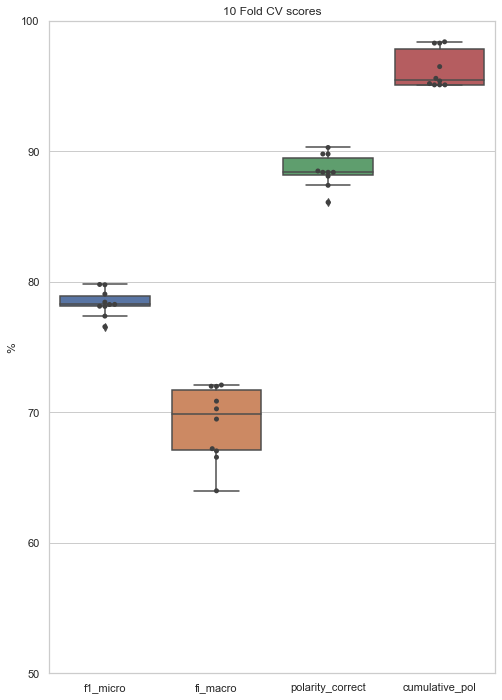

In [60]:
'''
These are the scores from the ten randomly generated splits from Spyder
'''

f1_scores_micro_ = [78.12340642529321, 79.79949874686717, 78.27426810477658, 79.77811396873423, 78.26541274817136,
                    76.56565656565655, 78.44342037890425, 78.13292744799594, 77.37603305785125, 79.06281156530409]

f1_scores_macro_ = [63.98552073828816, 71.99846708491022, 67.0423993610601, 71.99051669698557, 67.21391648328867, 
                    66.55676248639132, 70.8567117894718, 70.26718414852915, 69.48191591312455, 72.09332366027145]

polarity_true_scores = [89.8, 89.8, 86.1, 90.3, 88.1, 87.4, 88.4, 88.5, 88.4, 88.4]

cumulative_pol_true = [95.1, 98.4, 95.19999999999999, 95.39999999999999, 98.3, 95.1, 96.5, 95.6, 98.3, 95.1]

boxplot_data = pd.DataFrame([f1_scores_micro_, f1_scores_macro_, polarity_true_scores, cumulative_pol_true]).T

boxplot_data.columns = ['f1_micro', 'fi_macro', 'polarity_correct', 'cumulative_pol']

plt.figure(figsize=(8,12))
ax2 = sns.boxplot(data=boxplot_data)
ax2 = sns.swarmplot(data=boxplot_data, color=".25")

ax2.set(ylabel = '%', title='10 Fold CV scores')
plt.ylim(50, 100)
plt.show()

Let's have a look at a bunch of the instances where we got the polarity prediction wrong to see what's going on. Here's a screenshot of a portion of the 'all_preds_actuals' DataFrame filtered to instances where the polarity prediction is incorrect:

![Spyder DataFrame](img/incorrect_polarity_.png)

There's a number of single word messages here that we got incorrect, but many of these are variants or slang for empathy words. Improving the representation by using word vectors from GloVe/word2vec incorporating mispellings, synonyms and slang might help here though we'd need to have a discussion about what is acceptable from a clinical point of view. Is 'fine' the same as 'okay'? Someone might enter 'grand'. Is this 'okay', or is it more like 'good' (as it would be in an Irish context) or is it more expressive of being better than good?

In any case, scanning over these incorrect predictions has fed into a number of ideas we could implement to improve performance. I've detailed these below.


Ideas to improve performance:
 - More data
 - A balanced dataset, even if that's a subset of a larger corpus
 - Cleaner data - there's still a some unicode characters not completely cleaned from what I've used here
 - Further to this, we could try running the messages through a spelling corrector, might clean up some cases where we have 'abd' instead of 'bad', 'tierd' for 'tired', 'dissapointed' (and numerous variants) as 'disappointed' and so on
 - At one point I was thinking of trying a simple hash table lookup as many of the messages seem to have the empathy word or a close synonym as an adjective. I didn't do this in the end but we could try to augment what I've already done by using SpaCy or GloVe or word2vec to get pre-trained vectors for such words and compare them for similarity to the word vectors for empathies. We could look at using this as a sanity pass for predictions where the probability is below a certain threshold either.
 - In theory these word vectors could be used to put together an 'improved word vector' together with other features like part-of-speech tags, position information, there are some lexicons we could look at using that give polarity information. We could also try incorporating textblob - it does some kind of sentiment analysis/polarity rating that might be analagous to this task?
 - We could also incorporate synonyms of single word messages and also misspellings of these synonymns to automatically label instances.
 - Parameter search across TfidfVectorizer hyperparameters (max_df, ngram_range). Switching from unigrams to bigrams improved performance slightly.
 - Parameter search across algorithm hyperparameters (in the case of SVM, gamma, C, kernel, degree).
 - With a larger dataset there are more options in terms of architecture so we can look at deep learning methods, perhaps trying a co-learning method where we try to learn the exact empathy as a sub-task of categorising the polarity. BERT is state-of-the-art in terms of embeddings (prominent in Kaggle submissions) would be interesting to try. We name-checked transformers, LSTM and attention mechanisms in our last conversation.

### Glove

I also tried a GloVe representation but it was slightly outperformed by the tfidf. Code is below.

In [ ]:
'''
Code sources/resources:
https://github.com/nadbordrozd/blog_stuff/blob/master/classification_w2v/benchmarking_python3.ipynb
https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/
https://machinelearningmastery.com/clean-text-machine-learning-python/
'''

from tqdm import tqdm

#%%

# =============================================================================
# import zipfile
# 
# # Glove word embeddings
# # extracts the zipped file to the current working directory
# zip = zipfile.ZipFile('glove/glove.6B.zip')
# zip.extractall()
# 
# # extracts the zipped file to the current working directory
# zip = zipfile.ZipFile('glove/glove.840B.300d.zip')
# zip.extractall()
# encoding="utf-8"
# 
# GLOVE_6B_50D_PATH = "glove/glove.6B.50d.txt"
# GLOVE_840B_300D_PATH = "glove/glove.840B.300d.txt"
# =============================================================================

#%%
# =============================================================================
# all_words = set(w for words in cleaned_text_tokens for w in words)
# =============================================================================

#%%

# reading glove files, this may take a while
# we're reading line by line and only saving vectors
# that correspond to words from our training set
# if you wan't to play around with the vectors and have 
# enough RAM - remove the 'if' line and load everything

# import struct 

# =============================================================================
# glove_small = {}
# 
# with open(GLOVE_6B_50D_PATH, "rb") as infile:
#     for line in infile:
#         parts = line.split()
#         word = parts[0].decode(encoding)
#         if (word in all_words):
#             nums=np.array(parts[1:], dtype=np.float32)
#             glove_small[word] = nums
# 
#             
# glove_big = {}
# 
# with open(GLOVE_840B_300D_PATH, "rb") as infile:
#     for line in infile:
#         parts = line.split()
#         word = parts[0].decode(encoding)
#         if word in all_words:
#             nums=np.array(parts[1:], dtype=np.float32)
#             glove_big[word] = nums
# 
# 
# glove_other = {}
# 
# f = open(GLOVE_840B_300D_PATH, encoding="utf8")
# for line in tqdm(f):
#     values = line.split()
#     word = values[0]
#     try:
#        coefs = np.asarray(values[1:], dtype='float32')
#        glove_other[word] = coefs
#     except ValueError:
#        pass
# f.close()
# print('Found %s word vectors.' % len(glove_other))
# =============================================================================

#%%
# https://www.kaggle.com/eswarbabu88/toxic-comment-glove-logistic-regression
            

# =============================================================================
# def sent2vec(s):
#     words = str(s).lower()
#     words = word_tokenize(words)
#     words = [w for w in words if not w in stop_words]
#     words = [w for w in words if w.isalpha()]
#     M = []
#     for w in words:
#         try:
#             M.append(glove_other[w])
#         except:
#             continue
#     M = np.array(M)
#     v = M.sum(axis=0)
#     if type(v) != np.ndarray:
#         return np.zeros(300)
#     return v / np.sqrt((v ** 2).sum())
# 
# # create sentence vectors using the above function for training and validation set
# glove_data = [sent2vec(x) for x in tqdm(empathy_data_all['message'])]
# =============================================================================


#%%

# Formulate train/test splits for Glove
# =============================================================================
# xtrain, xval, ytrain, yval = train_test_split(glove_data,
#                                               y,
#                                               test_size=0.2,
#                                               random_state=9)  # was 9
# =============================================================================


In [1]:
#%% GLOVE
# =============================================================================
# # fit model on train data
# clf_lr.fit(xtrain, ytrain)
# # make predictions for validation set
# y_pred_lr = clf_lr.predict(xval)
# 
# # fit model on train data
# clf_svm.fit(xtrain, ytrain)
# # make predictions for validation set
# y_pred_svm = clf_svm.predict(xval)
# 
# # fit model on train data
# clf_mnb.fit(xtrain, ytrain)
# # make predictions for validation set
# y_pred_mnb = clf_mnb.predict(xval)
# =============================================================================

# =============================================================================
# # predict probabilities - glove
# y_pred_prob_lr = clf_lr.predict_proba(xval)
# y_pred_prob_svm = clf_svm.predict_proba(xval)
# y_pred_prob_mnb = clf_mnb.predict_proba(xval)
# =============================================================================

'/Users/billcoleman/NOTEBOOKS/WOEBOT'